#dependencies

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import pandas as pd
import os
import shutil

import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [3]:
print('dn')

dn


In [4]:
tf.__version__

'2.5.0'

#import data

In [5]:
df = pd.read_csv('train.csv')
sub = pd.read_csv('sample_submission.csv')
GCS_DS_PATH = 'gs://kds-c0e7d059f0c458599814e594a1cf6bcd0d5213a258c8a18944ad84ba'
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
df.shape

(1821, 5)

In [8]:
data=df[df['multiple_diseases']!=1]

In [9]:
data.shape

(1730, 5)

In [10]:
data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
5,Train_5,1,0,0,0


In [11]:
data.drop(columns='multiple_diseases', inplace=True)

C:\Users\zakaria\anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
data.shape

(1730, 4)

In [13]:
IMG_SIZE = 224

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 2048
seed_everything(seed)
print("REPLICAS: ", 8)



#paths

data_paths = data.image_id.apply(lambda x: 'images/' + x + '.jpg').values


#labels

data_labels = data.loc[:, ['healthy','scab','rust']].values

#split train data to train and valisation data 
train_paths, test_paths, train_labels, test_labels =train_test_split(data_paths, data_labels, test_size=0.2, random_state=seed)

SPLIT_VALIDATION =True
if SPLIT_VALIDATION:
    train_paths, valid_paths, train_labels, valid_labels =train_test_split(train_paths, train_labels, test_size=0.2, random_state=seed)
print(len(train_paths))
print(len(test_paths))
print(len(valid_paths))

def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

REPLICAS:  8
1107
346
277


#building the dataset(train, test, validation) 

In [14]:
BATCH_SIZE = 8

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

train_dataset_1 = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(8)
    .prefetch(AUTO)
)


valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(8)
    .cache()
    .prefetch(AUTO)
)


test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths, test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)



#hyperparametres

In [15]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

#data visualisation 

(1365, 2048, 3)


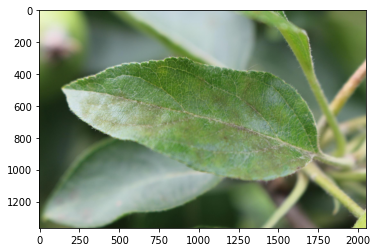

In [16]:
from matplotlib import pyplot as plt

img = plt.imread('images/Train_7.jpg')
print(img.shape)
plt.imshow(img)

image_id    Train_0Train_2Train_3Train_4Train_5Train_7Trai...
healthy                                                   516
rust                                                      622
scab                                                      592
dtype: object


<ipython-input-17-089b829e98a5>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts = data.mean()


<AxesSubplot:>

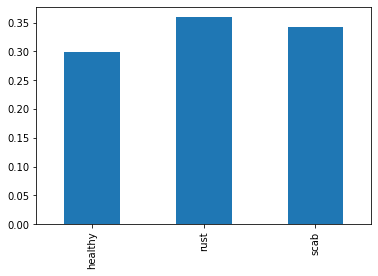

In [17]:
print(data.sum())
pcts = data.mean()
pcts.plot(kind = 'bar')

<AxesSubplot:ylabel='None'>

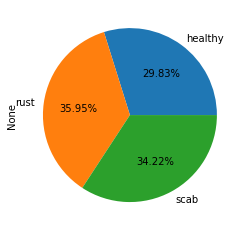

In [18]:
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [19]:
import h5py
h5py.__version__

'3.1.0'

#building our model

In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow import keras
IMG_SIZE=224

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet')
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model =  keras.Model(inputs = base_model.input,outputs=x)

model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [22]:

history=model.fit(
    train_dataset,
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    epochs=40,
    validation_data=valid_dataset)

Epoch 1/40
138/138 [==============================] - 56s 236ms/step - loss: 0.6156 - accuracy: 0.8107 - val_loss: 4.8137 - val_accuracy: 0.6354
Epoch 2/40
138/138 [==============================] - 14s 101ms/step - loss: 0.3147 - accuracy: 0.9022 - val_loss: 5.1920 - val_accuracy: 0.4982
Epoch 3/40
138/138 [==============================] - 14s 100ms/step - loss: 0.2153 - accuracy: 0.9230 - val_loss: 7.7260 - val_accuracy: 0.4260
Epoch 4/40
138/138 [==============================] - 14s 100ms/step - loss: 0.2696 - accuracy: 0.9176 - val_loss: 13.1106 - val_accuracy: 0.4296
Epoch 5/40
138/138 [==============================] - 14s 100ms/step - loss: 0.2701 - accuracy: 0.9176 - val_loss: 1.7803 - val_accuracy: 0.6823
Epoch 6/40
138/138 [==============================] - 14s 102ms/step - loss: 0.2817 - accuracy: 0.9103 - val_loss: 2.6769 - val_accuracy: 0.4910
Epoch 7/40
138/138 [==============================] - 13s 98ms/step - loss: 0.1595 - accuracy: 0.9538 - val_loss: 6.0926 - val_ac

#show the loss and the accuracy 

In [23]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

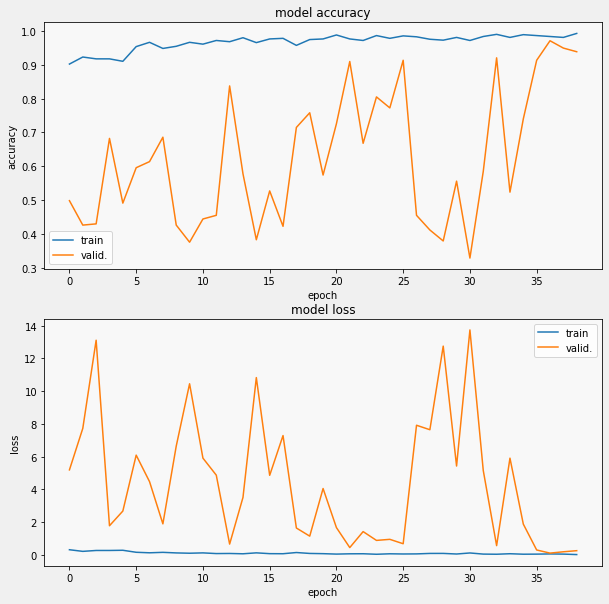

In [24]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [25]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, batch_size=8)
print("test loss, test acc:", results)


Evaluate on test data
44/44 [==============================] - 11s 217ms/step - loss: 0.3719 - accuracy: 0.9277
test loss, test acc: [0.37187790870666504, 0.9277456402778625]


In [26]:
import pickle
with open('training_log/MobileNetV2_kaggle1.pkl', 'wb') as output:
        pickle.dump(history.history, output)

In [27]:
model.save('MobileNetV2')

C:\Users\zakaria\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: MobileNetV2\assets
